In [1]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])



# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

Files already downloaded and verified


In [2]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.relu = F.relu()
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = F.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        #self.relu = F.relu()
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [3]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate


historycifarelu={'relu_train_loss':[],'relu_valid_loss':[],'relu_train_acc':[],'relu_valid_acc':[]}

for epoch in range(num_epochs):
    relu_train_loss,relu_train_correct=0.0,0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        relu_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(outputs.data, 1)#最大化输出得到标签0-9
        relu_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
        # if (i+1) % 100 == 0:
        #     print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
        #            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    relu_valid_loss, relu_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        relu_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        relu_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    relu_train_loss = relu_train_loss / len(train_loader.sampler)#除以48000
    relu_train_acc = relu_train_correct / len(train_loader.sampler)*100
    relu_valid_loss = relu_valid_loss / len(test_loader.sampler)#除以12000
    relu_valid_acc = relu_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         relu_train_loss,
                                                                                         relu_valid_loss,
                                                                                         relu_train_acc,
                                                                                        relu_valid_acc))
    historycifarelu['relu_train_loss'].append(relu_train_loss)#每次训练和验证记录下来，后面画图   
    historycifarelu['relu_valid_loss'].append(relu_valid_loss)  
    historycifarelu['relu_train_acc'].append(relu_train_acc)  
    historycifarelu['relu_valid_acc'].append(relu_valid_acc)  

Epoch:1/80 	 AVERAGE TL:1.4368 AVERAGE VL:1.4230 	 AVERAGE TA:47.04 %  AVERAGE VA:50.93 %
Epoch:2/80 	 AVERAGE TL:1.9800 AVERAGE VL:1.7133 	 AVERAGE TA:25.45 %  AVERAGE VA:35.55 %
Epoch:3/80 	 AVERAGE TL:1.6189 AVERAGE VL:1.4861 	 AVERAGE TA:39.44 %  AVERAGE VA:45.38 %
Epoch:4/80 	 AVERAGE TL:1.4411 AVERAGE VL:1.3845 	 AVERAGE TA:47.05 %  AVERAGE VA:49.16 %
Epoch:5/80 	 AVERAGE TL:1.2841 AVERAGE VL:1.1689 	 AVERAGE TA:53.32 %  AVERAGE VA:57.00 %
Epoch:6/80 	 AVERAGE TL:1.1457 AVERAGE VL:1.0725 	 AVERAGE TA:58.31 %  AVERAGE VA:61.79 %
Epoch:7/80 	 AVERAGE TL:1.0554 AVERAGE VL:1.0022 	 AVERAGE TA:61.81 %  AVERAGE VA:64.10 %
Epoch:8/80 	 AVERAGE TL:0.9747 AVERAGE VL:0.9476 	 AVERAGE TA:65.19 %  AVERAGE VA:66.88 %
Epoch:9/80 	 AVERAGE TL:0.9067 AVERAGE VL:0.8832 	 AVERAGE TA:67.76 %  AVERAGE VA:69.35 %
Epoch:10/80 	 AVERAGE TL:0.8379 AVERAGE VL:0.8212 	 AVERAGE TA:70.32 %  AVERAGE VA:71.38 %
Epoch:11/80 	 AVERAGE TL:0.7919 AVERAGE VL:0.7790 	 AVERAGE TA:72.34 %  AVERAGE VA:72.96 %
Epoch:12

In [5]:
import pandas as pd
frame1=pd.DataFrame(historycifarelu)
frame1.to_csv('D:/贝叶斯优化与噪声注入/historycifarelu.csv')

In [7]:
# GELU 高斯误差线性单元

In [10]:
import math
class Pgelu(nn.Module): #带参数的gelu激活函数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1)) #可学习参数 sigma 

    def forward(self, input):
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2


# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.relu = nn.ReLU()
        self.pgelu1 = Pgelu()
        self.pgelu2 = Pgelu()
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        #out = self.relu(out)
        out = self.pgelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.pgelu2(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        #self.relu = nn.ReLU()
        self.pgelu3 = Pgelu()
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        #out = self.relu(out)
        out = self.pgelu3(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
#model1 = ResidualBlock()
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#各个含有GELU的激活函数赋初值
z=model.pgelu3.sigma 
nn.init.constant_(z,6)
z101=model.layer1[0].pgelu1.sigma 
nn.init.constant_(z101,3)
z102=model.layer1[0].pgelu2.sigma 
nn.init.constant_(z102,3)
z111=model.layer1[1].pgelu1.sigma 
nn.init.constant_(z111,3)
z112=model.layer1[1].pgelu2.sigma 
nn.init.constant_(z112,3)
z201=model.layer2[0].pgelu1.sigma 
nn.init.constant_(z201,3)
z202=model.layer2[0].pgelu2.sigma 
nn.init.constant_(z202,3)
z211=model.layer2[1].pgelu1.sigma 
nn.init.constant_(z211,3)
z212=model.layer2[1].pgelu2.sigma 
nn.init.constant_(z212,3)
z301=model.layer3[0].pgelu1.sigma 
nn.init.constant_(z301,3)
z302=model.layer3[0].pgelu2.sigma 
nn.init.constant_(z302,3)
z311=model.layer3[1].pgelu1.sigma 
nn.init.constant_(z311,3)
z312=model.layer3[1].pgelu2.sigma 
nn.init.constant_(z312,3)
############################################

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate


historycifapgelu={'PGELU_train_loss':[],'PGELU_valid_loss':[],'PGELU_train_acc':[],'PGELU_valid_acc':[]}
num_epochs=80

for epoch in range(num_epochs):
    PGELU_train_loss,PGELU_train_correct=0.0,0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        PGELU_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(outputs.data, 1)#最大化输出得到标签0-9
        PGELU_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
        
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    PGELU_valid_loss, PGELU_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        PGELU_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        PGELU_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    PGELU_train_loss = PGELU_train_loss / len(train_loader.sampler)#除以48000
    PGELU_train_acc = PGELU_train_correct / len(train_loader.sampler)*100
    PGELU_valid_loss = PGELU_valid_loss / len(test_loader.sampler)#除以12000
    PGELU_valid_acc = PGELU_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         PGELU_train_loss,
                                                                                         PGELU_valid_loss,
                                                                                         PGELU_train_acc,
                                                                                        PGELU_valid_acc))
    historycifapgelu['PGELU_train_loss'].append(PGELU_train_loss)#每次训练和验证记录下来，后面画图   
    historycifapgelu['PGELU_valid_loss'].append(PGELU_valid_loss)  
    historycifapgelu['PGELU_train_acc'].append(PGELU_train_acc)  
    historycifapgelu['PGELU_valid_acc'].append(PGELU_valid_acc)  

Epoch:1/80 	 AVERAGE TL:1.4766 AVERAGE VL:1.3156 	 AVERAGE TA:45.78 %  AVERAGE VA:55.22 %
Epoch:2/80 	 AVERAGE TL:1.2380 AVERAGE VL:1.0601 	 AVERAGE TA:55.09 %  AVERAGE VA:63.04 %
Epoch:3/80 	 AVERAGE TL:0.9548 AVERAGE VL:0.8827 	 AVERAGE TA:66.00 %  AVERAGE VA:68.63 %
Epoch:4/80 	 AVERAGE TL:0.8381 AVERAGE VL:0.8525 	 AVERAGE TA:70.37 %  AVERAGE VA:70.22 %
Epoch:5/80 	 AVERAGE TL:0.7489 AVERAGE VL:0.7352 	 AVERAGE TA:73.56 %  AVERAGE VA:74.38 %
Epoch:6/80 	 AVERAGE TL:0.6777 AVERAGE VL:0.7007 	 AVERAGE TA:76.30 %  AVERAGE VA:76.79 %
Epoch:7/80 	 AVERAGE TL:0.6270 AVERAGE VL:0.6226 	 AVERAGE TA:78.21 %  AVERAGE VA:78.58 %
Epoch:8/80 	 AVERAGE TL:0.5874 AVERAGE VL:0.6104 	 AVERAGE TA:79.66 %  AVERAGE VA:78.91 %
Epoch:9/80 	 AVERAGE TL:0.5518 AVERAGE VL:0.5696 	 AVERAGE TA:80.88 %  AVERAGE VA:80.34 %
Epoch:10/80 	 AVERAGE TL:0.5249 AVERAGE VL:0.5623 	 AVERAGE TA:81.68 %  AVERAGE VA:80.90 %
Epoch:11/80 	 AVERAGE TL:0.4989 AVERAGE VL:0.5695 	 AVERAGE TA:82.62 %  AVERAGE VA:81.51 %
Epoch:12

In [13]:
import pandas as pd
frame1=pd.DataFrame(historycifapgelu)
frame1.to_csv('D:/贝叶斯优化与噪声注入/historycifapgelu.csv')

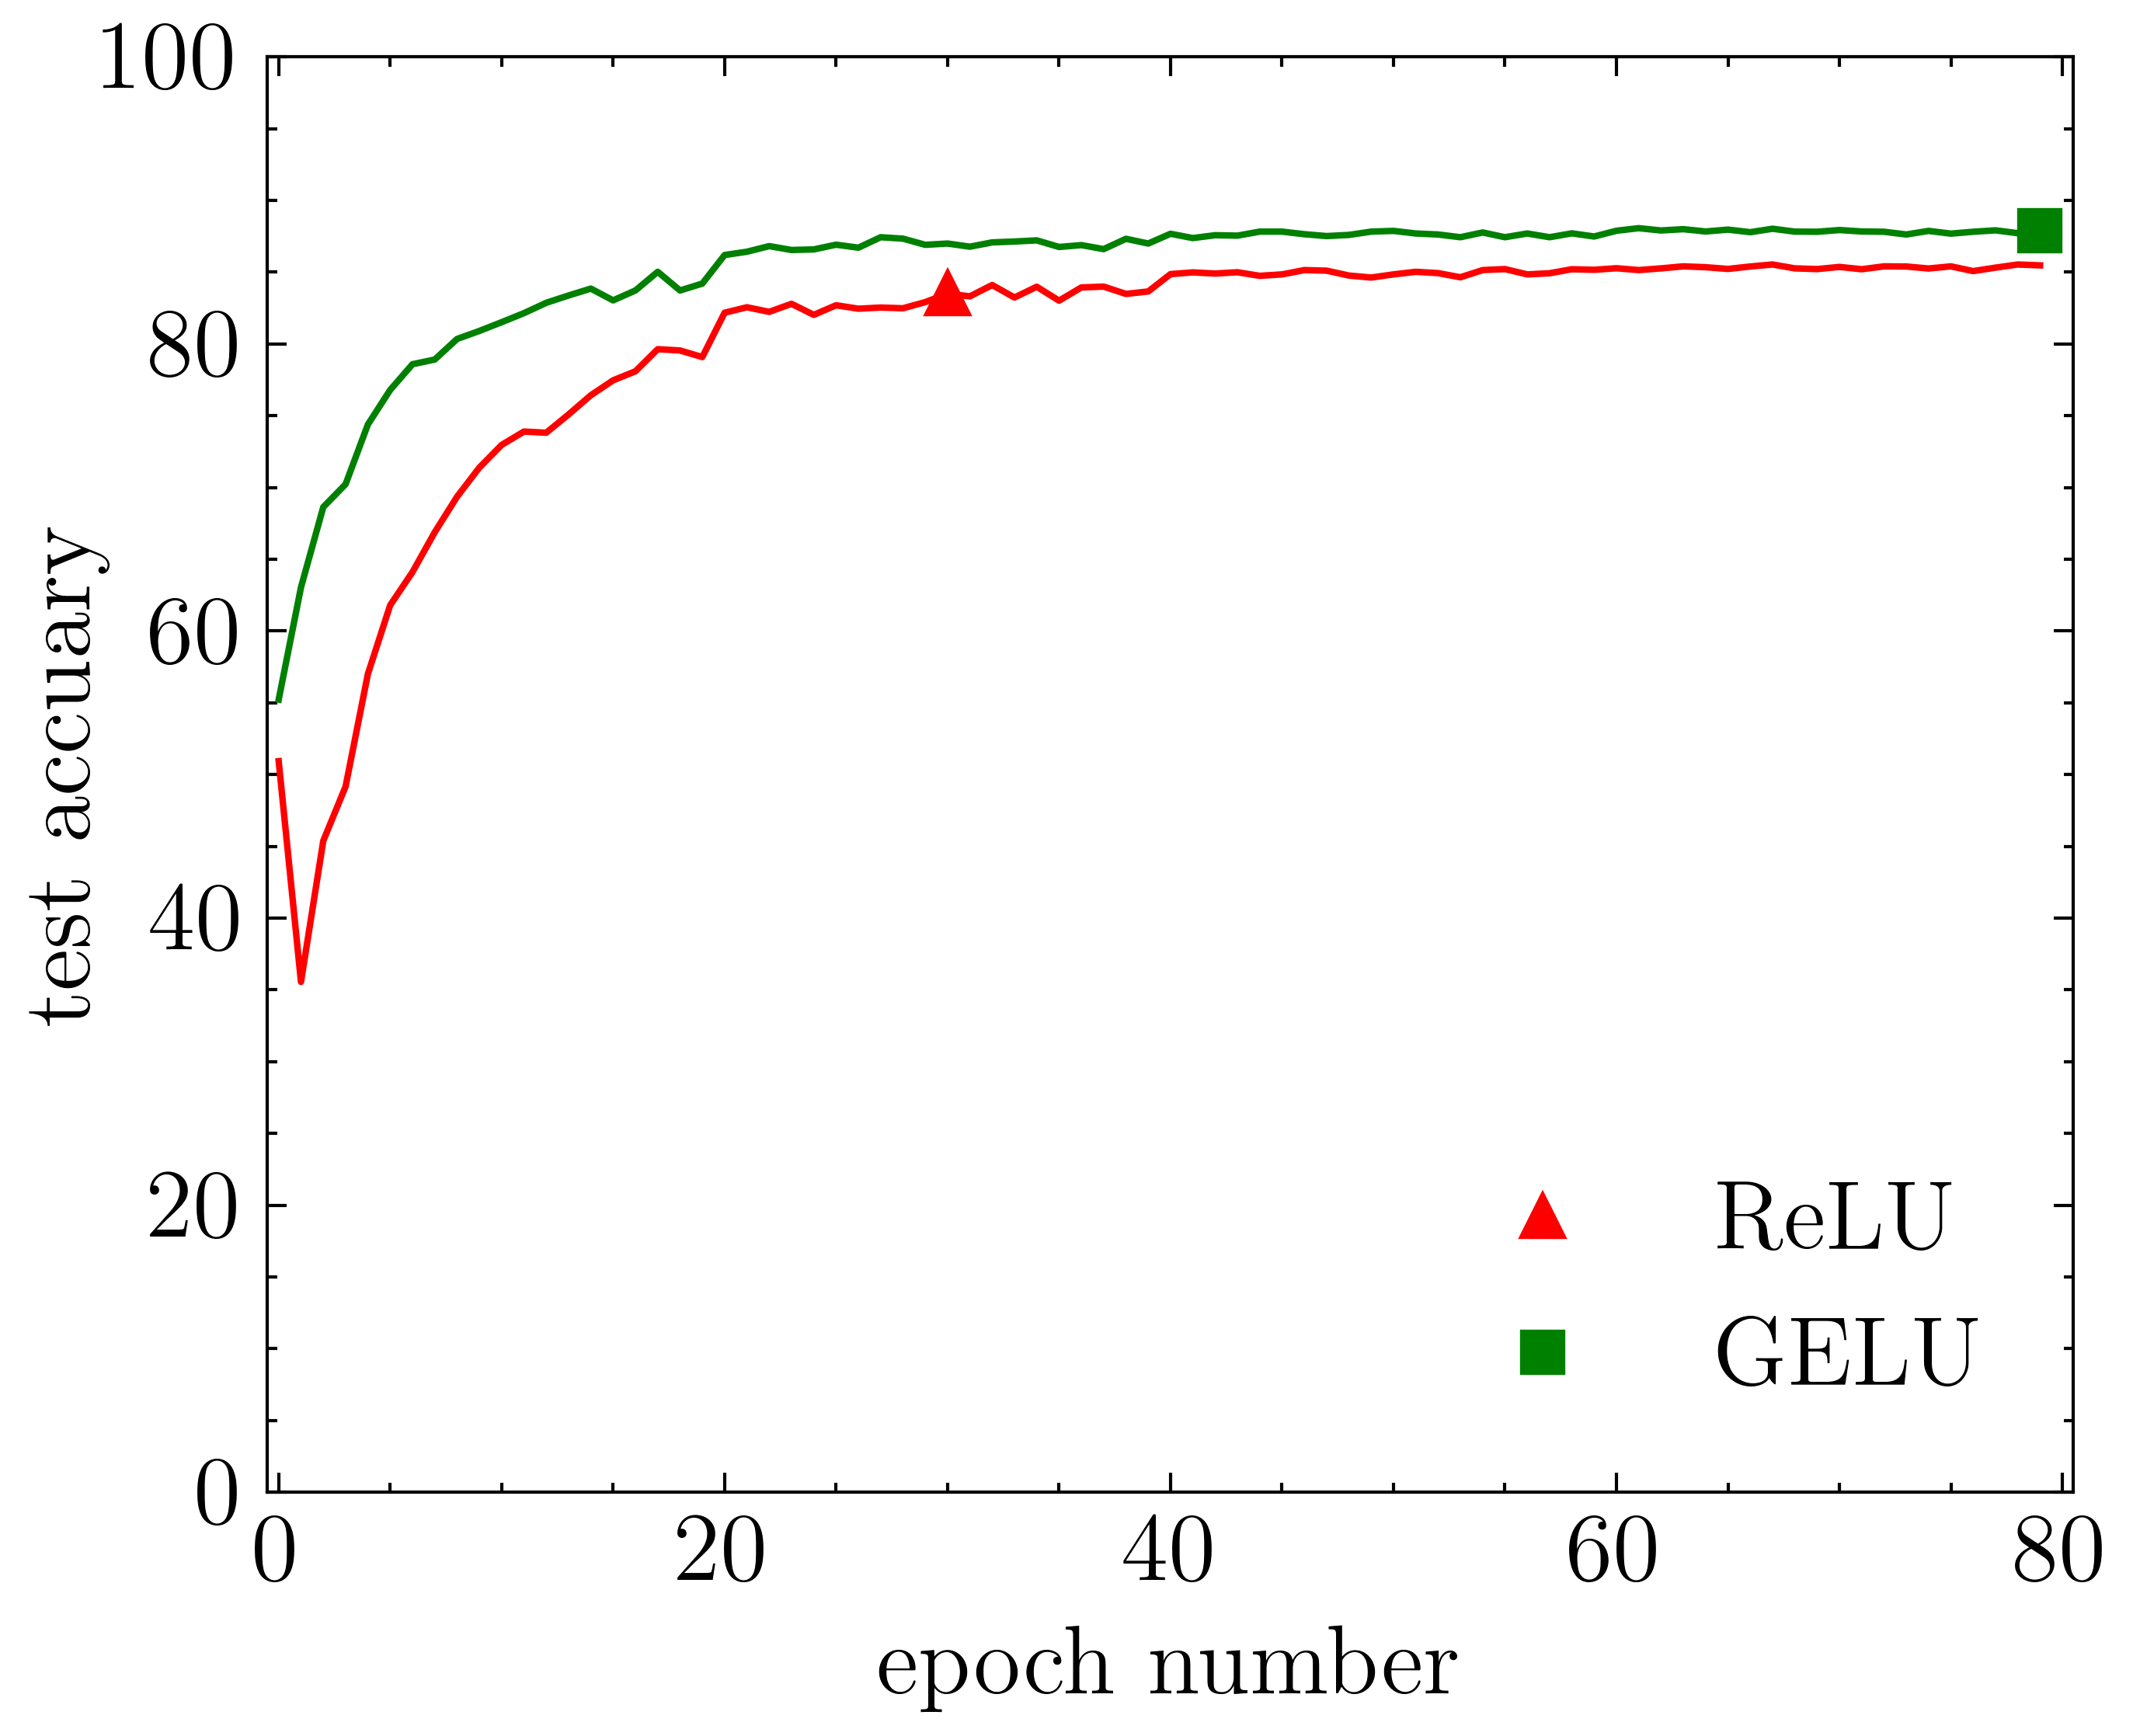

In [18]:
historycifarelu=pd.read_csv('D:/贝叶斯优化与噪声注入/historycifarelu.csv')
historycifapgelu=pd.read_csv('D:/贝叶斯优化与噪声注入/historycifapgelu.csv')
import scienceplots 

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('test accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 80.5)
ax.set_ylim(0, 100)


xrelu = range(0, 80)
yrelu = historycifarelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='r')
plt.plot(xrelu[30], yrelu[30], '^',color ='r',label='ReLU')

xpgelu = range(0, 80)
ypgelu = historycifapgelu['PGELU_valid_acc']
plt.plot(xpgelu, ypgelu, '-',color ='g')
plt.plot(xpgelu[79], ypgelu[79], 's',color ='g',label='GELU')

ax.legend(loc='lower right', fontsize=15)
#ax.text(-14, 99.8, '(a)',fontdict={'size': 15, 'color':  'black'})
plt.show()
#fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figminsta.eps', dpi=800)

In [40]:
#可以看出即使是残差这样的复杂神经网络结构，引入新的激活函数参数能够提高检测精度
#ReLU 的检测精度85.47 %，GELU引入了13个sigma参数，检测精度上升到87.90 %，>2%个百分点

#我们可以画出这13个sigma的终值

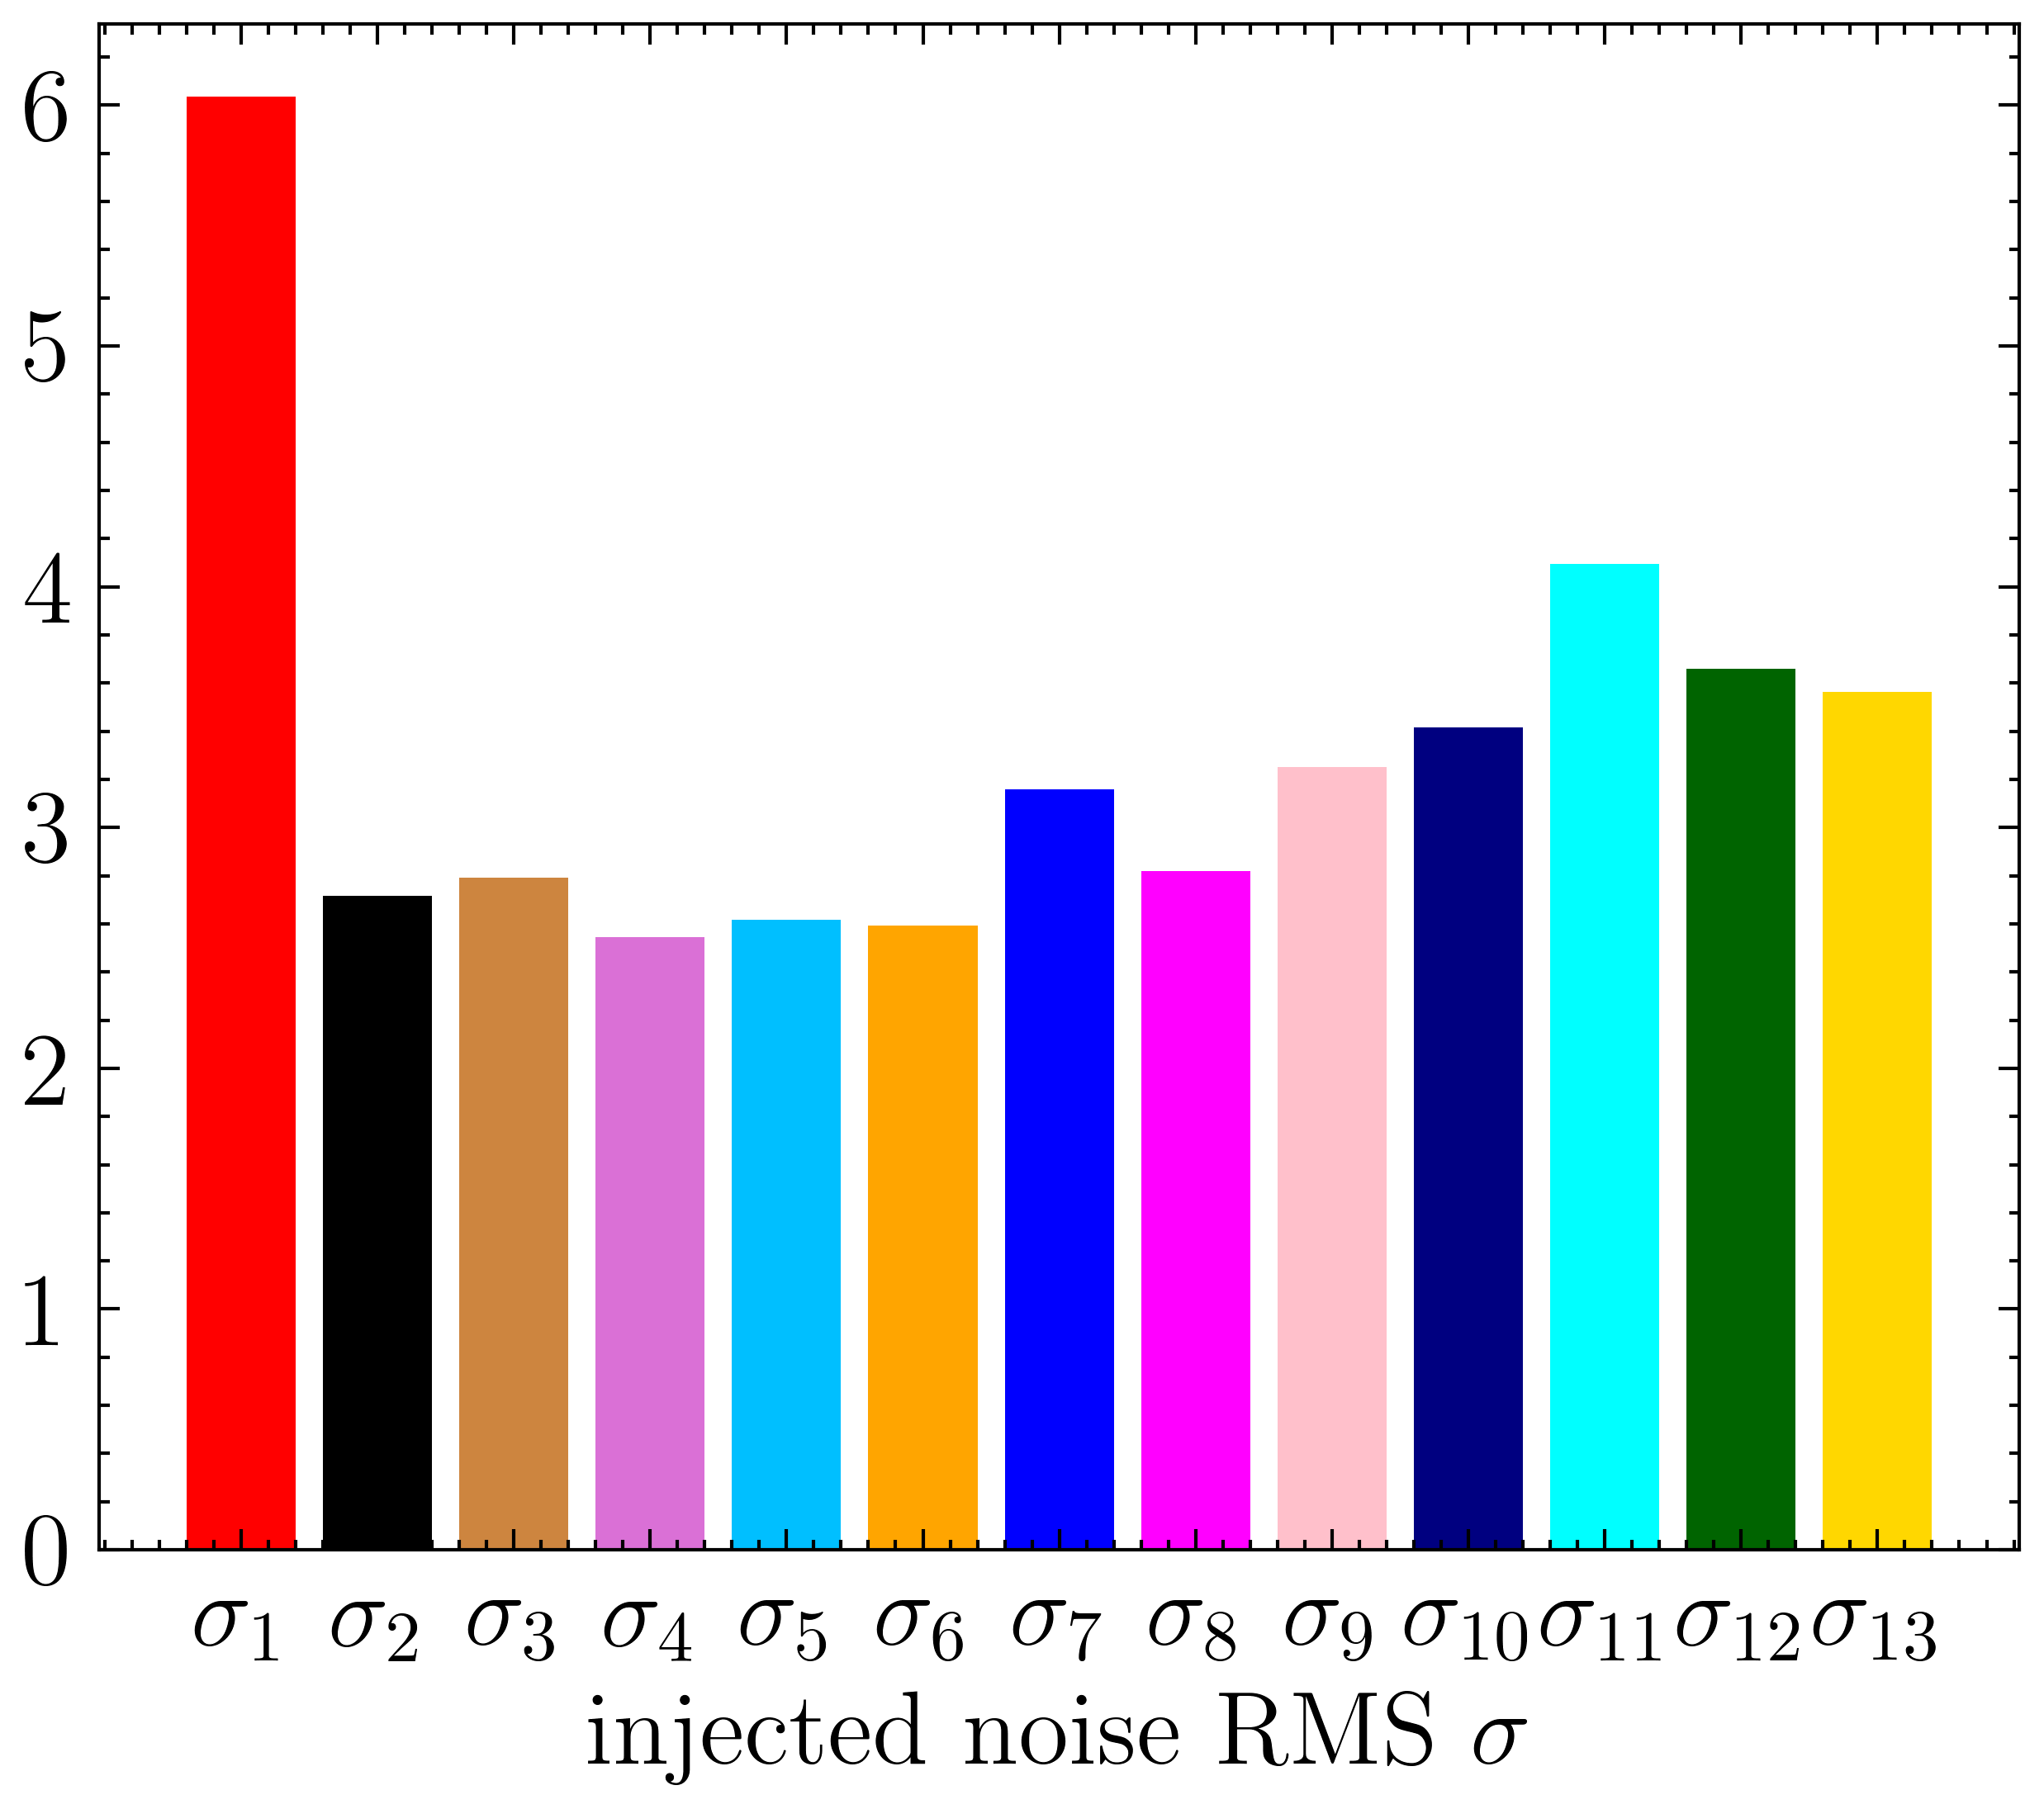

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('injected noise RMS $\sigma$', fontsize=15)
# 准备数据
x_data = [f"{i}" for i in range(1, 14)]
y_data = []
for tensor in [z, z101, z102, z111, z112, z201, z202, z211, z212, z301, z302, z311, z312]:
  # Assuming each tensor has only one element (based on the output)
  y_data.append(tensor.data.cpu().numpy()[0])  # Extract the first element
#y_data = [6.03538,2.7177,2.792176,2.543165,2.6173315,2.5918136,3.1576424,2.818159,3.2507248,3.4154792,4.0957046,3.6587691,3.563]

#color=['red','black','peru','orchid','deepskyblue', 'orange','blue', 'magenta', 'pink', 'navy', 'cyan', 'darkgreen', 'gold']
# 画图，plt.bar()可以画柱状图
#for i in range(len(x_data)):
plt.bar(x_data, y_data, color=['red','black','peru','orchid','deepskyblue', 'orange','blue', 'magenta', 'pink', 'navy', 'cyan', 'darkgreen', 'gold'])
# 设置图片名称
# 设置x轴标签名
#plt.xlabel("injected noise RMS")
# 设置y轴标签名
# 显示
plt.xticks([f"{i}" for i in range(1, 14)],['$\sigma_1$', '$\sigma_2$', '$\sigma_3$', '$\sigma_4$', '$\sigma_5$', '$\sigma_6$', '$\sigma_7$', '$\sigma_8$', '$\sigma_9$','$\sigma_{10}$', '$\sigma_{11}$', '$\sigma_{12}$', '$\sigma_{13}$'])
plt.show()


In [42]:
##看看其他激活函数，比如RayLU
class Raylu(nn.Module): #带参数的gelu激活函数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(2*torch.randn(1)) #可学习参数 sigma

    def forward(self, input):
        x = torch.where(input>=0, input, input*torch.exp(-input**2/self.sigma**2/2))
        return x

In [43]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.relu = nn.ReLU()
        self.Raylu1 = Raylu()
        self.Raylu2 = Raylu()
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        #out = self.relu(out)
        out = self.Raylu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.Raylu2(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        #self.relu = nn.ReLU()
        self.Raylu3 = Raylu()
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        #out = self.relu(out)
        out = self.Raylu3(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
#model1 = ResidualBlock()
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [44]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#各个含有GELU的激活函数赋初值
z=model.Raylu3.sigma 
nn.init.constant_(z,6)
z101=model.layer1[0].Raylu1.sigma 
nn.init.constant_(z101,3)
z102=model.layer1[0].Raylu2.sigma 
nn.init.constant_(z102,3)
z111=model.layer1[1].Raylu1.sigma 
nn.init.constant_(z111,3)
z112=model.layer1[1].Raylu2.sigma 
nn.init.constant_(z112,3)
z201=model.layer2[0].Raylu1.sigma 
nn.init.constant_(z201,3)
z202=model.layer2[0].Raylu2.sigma 
nn.init.constant_(z202,3)
z211=model.layer2[1].Raylu1.sigma 
nn.init.constant_(z211,3)
z212=model.layer2[1].Raylu2.sigma 
nn.init.constant_(z212,3)
z301=model.layer3[0].Raylu1.sigma 
nn.init.constant_(z301,3)
z302=model.layer3[0].Raylu2.sigma 
nn.init.constant_(z302,3)
z311=model.layer3[1].Raylu1.sigma 
nn.init.constant_(z311,3)
z312=model.layer3[1].Raylu2.sigma 
nn.init.constant_(z312,3)
############################################

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate


historycifaRaylu={'Raylu_train_loss':[],'Raylu_valid_loss':[],'Raylu_train_acc':[],'Raylu_valid_acc':[]}
num_epochs=80

for epoch in range(num_epochs):
    Raylu_train_loss,Raylu_train_correct=0.0,0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        Raylu_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(outputs.data, 1)#最大化输出得到标签0-9
        Raylu_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
        
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    Raylu_valid_loss, Raylu_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        Raylu_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        Raylu_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    Raylu_train_loss = Raylu_train_loss / len(train_loader.sampler)#除以48000
    Raylu_train_acc = Raylu_train_correct / len(train_loader.sampler)*100
    Raylu_valid_loss = Raylu_valid_loss / len(test_loader.sampler)#除以12000
    Raylu_valid_acc = Raylu_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         Raylu_train_loss,
                                                                                         Raylu_valid_loss,
                                                                                         Raylu_train_acc,
                                                                                        Raylu_valid_acc))
    historycifaRaylu['Raylu_train_loss'].append(Raylu_train_loss)#每次训练和验证记录下来，后面画图   
    historycifaRaylu['Raylu_valid_loss'].append(Raylu_valid_loss)  
    historycifaRaylu['Raylu_train_acc'].append(Raylu_train_acc)  
    historycifaRaylu['Raylu_valid_acc'].append(Raylu_valid_acc) 

Epoch:1/80 	 AVERAGE TL:1.6302 AVERAGE VL:1.3617 	 AVERAGE TA:39.46 %  AVERAGE VA:50.22 %
Epoch:2/80 	 AVERAGE TL:1.2219 AVERAGE VL:1.0132 	 AVERAGE TA:55.64 %  AVERAGE VA:63.20 %
Epoch:3/80 	 AVERAGE TL:0.9788 AVERAGE VL:0.8999 	 AVERAGE TA:65.11 %  AVERAGE VA:67.74 %
Epoch:4/80 	 AVERAGE TL:0.8587 AVERAGE VL:0.8178 	 AVERAGE TA:69.38 %  AVERAGE VA:70.99 %
Epoch:5/80 	 AVERAGE TL:0.7752 AVERAGE VL:0.7814 	 AVERAGE TA:72.53 %  AVERAGE VA:72.93 %
Epoch:6/80 	 AVERAGE TL:0.7052 AVERAGE VL:0.6634 	 AVERAGE TA:75.11 %  AVERAGE VA:77.13 %
Epoch:7/80 	 AVERAGE TL:0.6444 AVERAGE VL:0.6421 	 AVERAGE TA:77.35 %  AVERAGE VA:77.98 %
Epoch:8/80 	 AVERAGE TL:0.5987 AVERAGE VL:0.7135 	 AVERAGE TA:79.10 %  AVERAGE VA:75.49 %
Epoch:9/80 	 AVERAGE TL:0.5619 AVERAGE VL:0.6075 	 AVERAGE TA:80.36 %  AVERAGE VA:79.26 %
Epoch:10/80 	 AVERAGE TL:0.5292 AVERAGE VL:0.5717 	 AVERAGE TA:81.58 %  AVERAGE VA:81.12 %
Epoch:11/80 	 AVERAGE TL:0.5029 AVERAGE VL:0.5533 	 AVERAGE TA:82.50 %  AVERAGE VA:81.17 %
Epoch:12

In [55]:
##optuna######
###耗费时间的过程。。。。。。。。。。。。。。。

import optuna
class Pgelu(nn.Module): #带参数的gelu激活函数
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'sigma_{seqFlag}',0,10) #可学习参数 sigma
#在这个字符串格式中，f-string 中的 {} 用于引用变量或表达式的值。在你提供的代码中，
#f'$\sigma_{seqFlag}$' 中的 {} 用于将 seqFlag 的值插入到字符串中，形成一个带有动态值的字符串
    def forward(self, input):
        x = input*(1+torch.erf(input/math.sqrt(2)/self.sigma))/2
        return x

##########################################
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, trial, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.pgelu1 = Pgelu(1, trial)
        self.pgelu2 = Pgelu(2, trial)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.pgelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.pgelu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, trial, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.pgelu3 = Pgelu(3, trial)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.pgelu3(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def objective(trial):
    model = ResNet(trial, ResidualBlock, [2, 2, 2]).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # For updating learning rate
    def update_lr(optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Train the model
    total_step = len(train_loader)
    curr_lr = learning_rate



    num_epochs=80

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
        
            # Decay learning rate
            if (epoch+1) % 20 == 0:
                curr_lr /= 3
                update_lr(optimizer, curr_lr)
                
        PGELU_val_correct = 0.0, 0
        model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
        for images, labels in test_loader:
            images,labels = images.to(device),labels.to(device)
            outputs = model(images)
 
         
            scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
            PGELU_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

   
        PGELU_valid_acc = PGELU_val_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} \t AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs, PGELU_valid_acc))
    return PGELU_valid_acc
    
study = optuna.create_study(direction='maximize')

# 运行优化过程
study.optimize(objective, n_trials=10)

# 打印最佳参数和目标值
print('Best trial:')
print('  Value: ', study.best_trial.value)
print('  Params: ')
for key, value in study.best_trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-03-27 23:02:48,966] A new study created in memory with name: no-name-53d03672-357e-4620-8540-5cebc0a66a4a
[W 2024-03-27 23:02:48,969] Trial 0 failed with parameters: {'sigma_3': 3.8859870519796402} because of the following error: AttributeError("'int' object has no attribute 'suggest_float'").
Traceback (most recent call last):
  File "D:\DeepLearning\Anaconda\envs\torch2\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\FabingDuan\AppData\Local\Temp\ipykernel_7768\2746779891.py", line 85, in objective
    model = ResNet(trial, ResidualBlock, [2, 2, 2]).to(device)
  File "C:\Users\FabingDuan\AppData\Local\Temp\ipykernel_7768\2746779891.py", line 53, in __init__
    self.layer1 = self.make_layer(block, 16, layers[0])
  File "C:\Users\FabingDuan\AppData\Local\Temp\ipykernel_7768\2746779891.py", line 66, in make_layer
    layers.append(block(self.in_channels, out_channels, stride, downsample))
  File "C:\Users\

AttributeError: 'int' object has no attribute 'suggest_float'